In [2]:
# Import modules
import sqlite3
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Connect to sql database
con = sqlite3.connect("database.db")

In [4]:
%load_ext sql

In [5]:
%%sql sqlite:///database.db
SELECT * from campaign
LIMIT 5;

Done.


id,name,sub_category_id,country_id,currency_id,launched,deadline,goal,pledged,backers,outcome
1,Ragdolls,23,2,2,2013-04-25 00:00:00,2013-05-25 00:00:00,15000.0,20.0,3,failed
2,One To Ten,47,1,1,2015-11-16 00:00:00,2015-12-16 00:00:00,223.68,413.81,23,successful
3,Future Gun - A short film about kids and advanced hardware,24,2,2,2013-08-28 00:00:00,2013-09-27 00:00:00,5000.0,1497.0,28,failed
4,Fourth Wave ApparelVintage Fashion for the Modern Feminist,52,2,2,2014-07-22 00:00:00,2014-08-21 00:00:00,6000.0,8795.0,218,successful
5,The Rich Lifestyle,9,2,2,2016-08-24 00:00:00,2016-09-28 00:00:00,2000000.0,2.0,2,failed


In [6]:
%%sql
SELECT CASE WHEN
(outcome IN ("failed", "canceled","suspended","undefined")) THEN "unsuccessful"
ELSE outcome END AS outcome,
goal
FROM campaign
LIMIT 5;

 * sqlite:///database.db
Done.


outcome,goal
unsuccessful,15000.0
successful,223.68
unsuccessful,5000.0
successful,6000.0
unsuccessful,2000000.0


# Are the country_names for dollars raised significantly different between campaigns that are successful and unsuccessful?

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   outcome  547 non-null    category
 1   goal     547 non-null    float64 
dtypes: category(1), float64(1)
memory usage: 5.1 KB


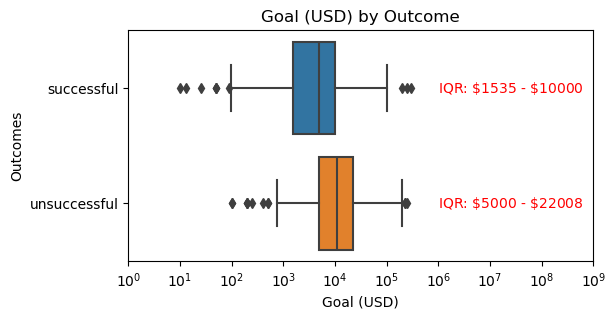

In [280]:
# Query the database for the goal and status of each campaign
df = pd.read_sql_query(
    """
SELECT CASE
         WHEN ( outcome IN ( "failed", "canceled", "suspended", "undefined" ) )
       THEN
         "unsuccessful"
         ELSE outcome
       END AS outcome,
       goal_usd AS goal
FROM   campaign  
INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.goal * exchange_rate.exchange_rate,
                          2) AS goal_usd
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
        ON t1.campaign_id = campaign.id
        WHERE campaign.sub_category_id = 14
        AND campaign.outcome != "live"
""",
    con,
)
df["outcome"] = df["outcome"].astype("category")
df["goal"] = df["goal"].apply(lambda x: np.log10(x))

# Check for missing values
df.info()

results = df.groupby("outcome").describe()
results["lower_95CI"] = results["goal"]["mean"] - 1.96 * results["goal"]["std"] / np.sqrt(results["goal"]["count"])
results["upper_95CI"] = results["goal"]["mean"] + 1.96 * results["goal"]["std"] / np.sqrt(results["goal"]["count"])
results["mean"] = results["goal"]["mean"].apply(lambda x: 10**x)
results["lower_95CI"] = results["lower_95CI"].apply(lambda x: 10**x)
results["upper_95CI"] = results["upper_95CI"].apply(lambda x: 10**x)
results["25%"] = results["goal"]["25%"].apply(lambda x: 10**x)
results["50%"] = results["goal"]["50%"].apply(lambda x: 10**x)
results["75%"] = results["goal"]["75%"].apply(lambda x: 10**x)

# Create a boxplot
plt.figure(figsize=(6, 3))
sns.boxplot(y="outcome", x="goal", data=df)
# Change y-axis tick labels  to log scale
plt.xticks(np.arange(0, 10, 1), [f"$10^{{{y:.0f}}}$" for y in np.arange(0, 10, 1)])
plt.xlabel("Goal (USD)")
plt.ylabel("Outcomes")
#plt.title("Goal (USD) by Outcome")

# Add IQR labels
for i, outcome in enumerate(df['outcome'].unique()):
       lower = results.loc[outcome , ('goal', '25%')]
       upper = results.loc[outcome , ('goal', '75%')]
       plt.text( 6,i, f'IQR: ${{\${10**lower:.0f}}}$ - ${{\${10**upper:.0f}}}$', ha='left', va='center', color='red')
plt.show()



45.0434401941642 5.351226428882561e-11
               df      sum_sq    mean_sq         F        PR(>F)
C(outcome)    1.0   17.648026  17.648026  45.04344  5.351226e-11
Residual    489.0  191.590264   0.391800       NaN           NaN


<Figure size 300x400 with 0 Axes>

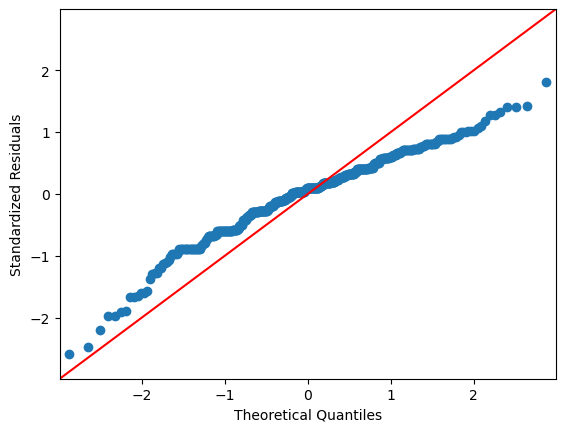

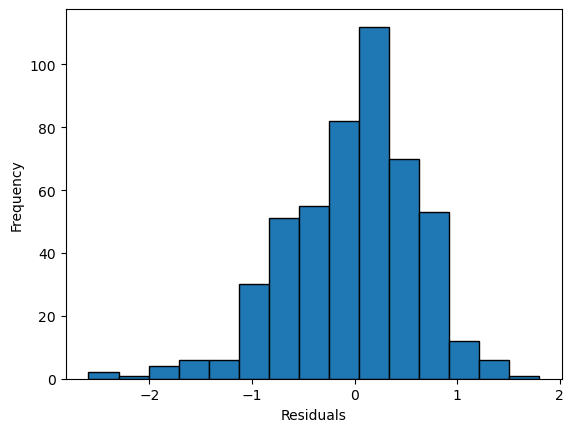

In [8]:
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = pd.read_sql_query(
    """
SELECT CASE
         WHEN ( outcome IN ( "failed", "canceled", "suspended", "undefined" ) )
       THEN
         "unsuccessful"
         ELSE outcome
       END AS outcome,
       goal_usd AS goal
FROM   campaign  
INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.goal * exchange_rate.exchange_rate,
                          2) AS goal_usd
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
        ON t1.campaign_id = campaign.id
        WHERE campaign.sub_category_id = 14
        AND campaign.outcome != "live"
        AND campaign.country_id IN (1,2,3)
""",
    con,
)
df["outcome"] = df["outcome"].astype("category")
df["goal"] = df["goal"].apply(lambda x: np.log10(x))
# Get the numeric values of the 'goal' column for unsuccessful campaigns
unsuccessful_goals = df[df["outcome"] == "unsuccessful"]["goal"]

# Get the numeric values of the 'goal' column for successful campaigns
successful_goals = df[df["outcome"] == "successful"]["goal"]

# Perform ANOVA test
fvalue, pvalue = stats.f_oneway(unsuccessful_goals, successful_goals)
print(fvalue, pvalue)
# Summary output of ANOVA test
model = ols("goal ~ C(outcome)", data=df).fit()
aov_table = sm.stats.anova_lm(model, typ=1)
print(aov_table)
# Check qqplot of residuals
plt.figure(figsize=(3, 4))
sm.qqplot(model.resid, line="45")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()
# histogram of residuals
plt.hist(model.resid, bins=15, histtype="bar", ec="k")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

In [9]:
results

goal                                                            \
              count      mean       std      min      25%       50%       75%   
outcome                                                                         
successful    294.0  3.608465  0.687464  1.00000  3.18609  3.698970  4.000000   
unsuccessful  253.0  4.002336  0.580872  1.99987  3.69897  4.041393  4.342588   

                         lower_95CI    upper_95CI          mean          25%  \
                   max                                                         
outcome                                                                        
successful    5.479856  3387.518773   4864.620687   4059.432707  1534.934961   
unsuccessful  5.397940  8526.254446  11855.316024  10053.926644  5000.000000   

                  50%       75%  
                                 
outcome                          
successful     5000.0  10000.00  
unsuccessful  11000.0  22008.36

# What are the top/bottom 3 categories with the most backers? What are the top/bottom 3 subcategories by backers?

In [10]:
#Get category name for each campaign
SQL_GET_CATEGORY = '''
SELECT campaign.id   AS campaign_id,
       category.NAME AS category_name
FROM   campaign,
       sub_category,
       category
WHERE  campaign.sub_category_id = sub_category.id
       AND category.id = sub_category.category_id
GROUP  BY campaign.id
'''

In [11]:
# Get subcategory name for each campaign
SQL_GET_SUBCATEGORY = '''
/* Get subcategory name for each campaign */
SELECT campaign.id as campaign_id,
                          sub_category.name AS subcategory_name
                   FROM   campaign,
                          sub_category
                   WHERE  campaign.sub_category_id = sub_category.id
                   GROUP  BY campaign.id
'''

In [12]:
# Build dataframe from SQL queries
def build_dataframe_from_queries(sql_queries: list, con: sqlite3.Connection):
    if len(sql_queries) == 1:
        return pd.read_sql_query(sql_queries[0], con)
    df1 = pd.read_sql_query(sql_queries[0], con)
    for sql_query in sql_queries[1:]:
        df = pd.read_sql_query(sql_query, con)
        df1 = pd.concat([df1, df])
    return df1

In [13]:
def get_top_bottom_3(func):
    # Get top 3
    top3 = func(ascending=False, limit=3)
    # Get bottom 3
    bottom3= func(ascending=True, limit=3)
    return [top3,bottom3]

### Top & Bottom 3 categories

    id category_name  num_backers
0   39         Games       411180
1   13    Technology       329467
2   22        Design       261270
2   10        Crafts        10383
1   82    Journalism         6206
0  129         Dance         6022


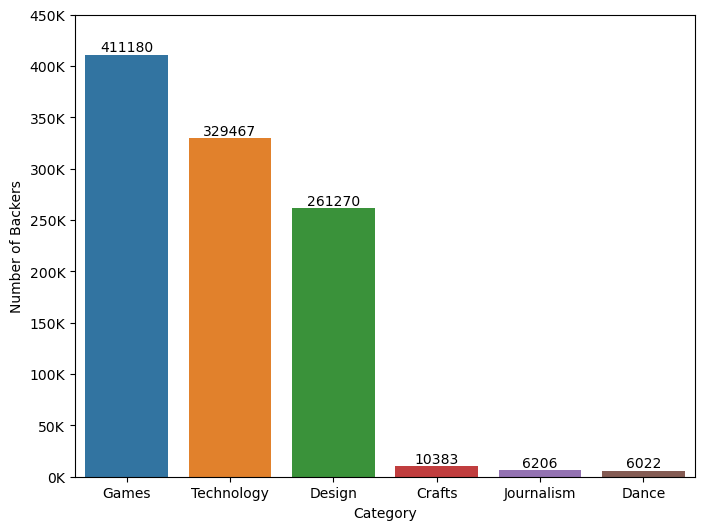

In [14]:
def build_query(ascending:bool, limit: int, SQL_GET_CATEGORY=SQL_GET_CATEGORY):
        query = f'''
                        SELECT campaign.id,
                                category_name,
                                Sum(backers) AS num_backers
                        FROM   campaign
                                INNER JOIN ({SQL_GET_CATEGORY}) AS category
                                        ON category.campaign_id = campaign.id
                        WHERE outcome != "live"
                        GROUP  BY category_name
                        ORDER  BY num_backers {"ASC" if ascending else "DESC"}
                        LIMIT  {limit};  
                '''
        return  query

# Build dataframe from SQL queries
df1 = build_dataframe_from_queries(get_top_bottom_3(build_query), con)
df1.sort_values(by="num_backers", ascending=False, inplace=True)
print(df1)

# Create visualization
plt.figure(figsize=(8,6))
sns.barplot(x="category_name", y="num_backers", data=df1)
plt.ylabel("Number of Backers")
plt.xlabel("Category")
plt.yticks(np.arange(0, 5e5, 0.5e5), [f"{y/1e3:.0f}K" for y in np.arange(0, 5e5, 0.5e5)])
for i, num_backers in enumerate(df1['num_backers']):
        plt.annotate(f"{num_backers}", (i, num_backers), ha='center', va='bottom')
plt.show()


### Top & Bottom 3 sub-categories

  subcategory_name  num_backers
0  Tabletop\nGames       246644
1  Product\nDesign       220982
2     Video\nGames       141048
2            Latin           13
1            Photo           12
0            Glass            2


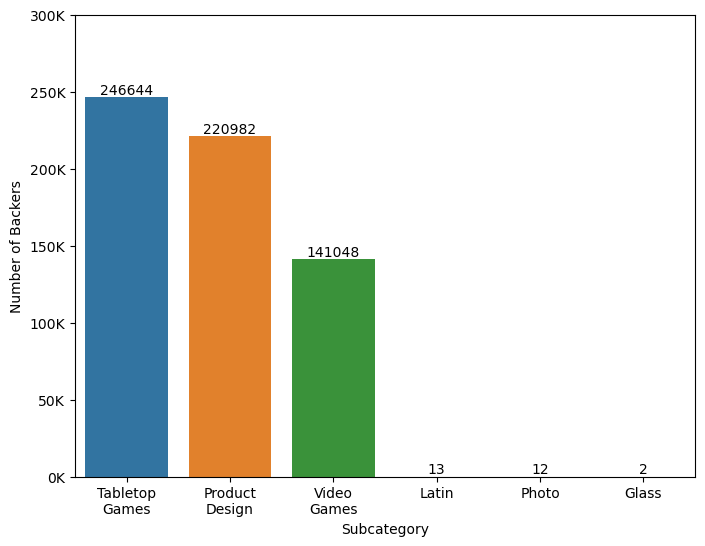

In [15]:
def build_query(ascending: bool, limit: int, SQL_GET_SUBCATEGORY=SQL_GET_SUBCATEGORY):
    query = f'''
                SELECT      subcategory_name,
                            Sum(backers) AS num_backers
                FROM        campaign
                INNER JOIN  ({SQL_GET_SUBCATEGORY}) as subcategory
                ON          subcategory.campaign_id = campaign.id
                WHERE outcome != "live"
                GROUP BY    subcategory_name
                ORDER BY    num_backers {"ASC" if ascending else "DESC"} 
                LIMIT       {limit}; 
            '''
    return query


# Build dataframe from SQL queries
df1 = build_dataframe_from_queries(get_top_bottom_3(build_query), con)
df1["subcategory_name"] = df1["subcategory_name"].apply(lambda x: x.replace(" ", "\n") if " " in x else x)
df1.sort_values(by="num_backers", ascending=False, inplace=True)
print(df1)

# Create visualization
plt.figure(figsize=(8,6))
sns.barplot(x="subcategory_name", y="num_backers", data=df1)
plt.ylabel("Number of Backers")
plt.xlabel("Subcategory")
plt.yticks(
    np.arange(0, 3.5e5, 0.5e5), [f"{y/1e3:.0f}K" for y in np.arange(0, 3.5e5, 0.5e5)]
)
for i, num_backers in enumerate(df1["num_backers"]):
    plt.annotate(f"{num_backers}", (i, num_backers), ha="center", va="bottom")
plt.show()

- The top 3 categories with the most backers are Games (411180), Technology (329467), and Design (261270).
- The bottom 3 categories with the fewest backers are Dance (6022), Journalism (6206), and Crafts (10383).
- The top 3 sub-categories with the most backers are Tabletop Games (246644), Product Design (220982), and Video Games (141048).
- The bottom 3 sub-categories with the fewest backers are Glass (2), Photo (2), and Latin (13).

# What are the top/bottom 3 categories that have raised the most money? What are the top/bottom 3 subcategories that have raised the most money?

### Top & Bottom 3 categories

In [17]:
# Calculate pledged_USD for each campaign
SQL_CAMPAIGN_PLEDGED_USD = '''
SELECT campaign.id as campaign_id,
                         Round(campaign.pledged * exchange_rate.exchange_rate, 2) AS pledged_usd,
                         campaign.outcome as outcome
                  FROM   campaign,
                         exchange_rate
                  WHERE  exchange_rate.currency_id = campaign.currency_id
                  AND    exchange_rate.deadline = Date(campaign.deadline)
'''

   campaign_id  pledged_usd category_name
0           39  29033808.81         Games
1           13  28051285.55    Technology
2           22  26301961.01        Design
2           10    608153.45        Crafts
1          129    511771.71         Dance
0           82    449729.70    Journalism


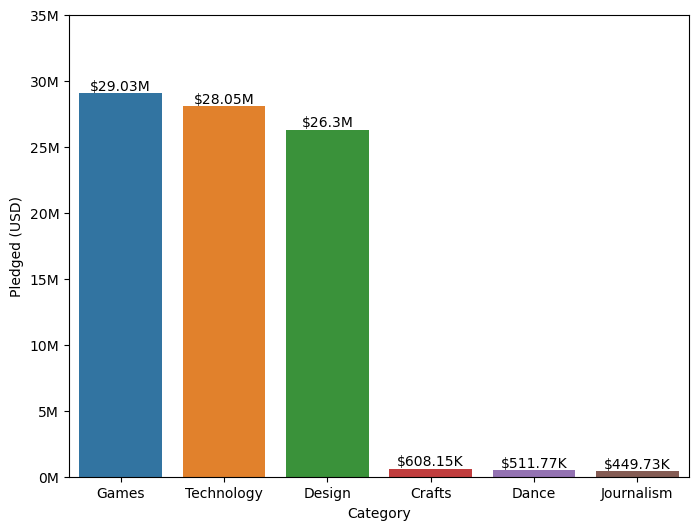

In [18]:
def build_query(ascending: bool, limit: int, SQL_GET_CATEGORY=SQL_GET_CATEGORY, SQL_CAMPAIGN_PLEDGED_USD = SQL_CAMPAIGN_PLEDGED_USD):
    query = f'''
                SELECT      t1.campaign_id,
                            Round(Sum(t1.pledged_usd),2) AS pledged_usd,
                            t2.category_name
                FROM        ( {SQL_CAMPAIGN_PLEDGED_USD} ) as t1
                INNER JOIN  ( {SQL_GET_CATEGORY})          AS t2
                ON          t1.campaign_id = t2.campaign_id
                WHERE       t1.outcome != "live"
                GROUP BY    t2.category_name
                ORDER BY    pledged_usd {"ASC" if ascending else "DESC"} limit {limit};  
            '''
    return query


# Build dataframe from SQL queries
df1 = build_dataframe_from_queries(get_top_bottom_3(build_query), con)
df1.sort_values(by="pledged_usd", ascending=False, inplace=True)
df1["category_name"] = df1["category_name"].apply(lambda x: x.replace(" ", "\n") if " " in x else x)
print(df1)

# Create visualization
plt.figure(figsize=(8,6))
sns.barplot(x="category_name", y="pledged_usd", data=df1)
plt.ylabel("Pledged (USD)")
plt.xlabel("Category")
plt.yticks(
    np.arange(0, 4e7, 0.5e7), [f"{y/1e6:.0f}M" for y in np.arange(0, 4e7, .5e7)]
)
for i, pledged_usd in enumerate(df1["pledged_usd"]):
    if pledged_usd >= 1e6:
        plt.annotate(f"${round(pledged_usd/1e6, 2)}M", (i, pledged_usd), ha="center", va="bottom")
    elif pledged_usd < 1e6:
        plt.annotate(f"${round(pledged_usd/1e3, 2)}K", (i, pledged_usd), ha="center", va="bottom")
plt.show()

### Top & Bottom 3 Subcategories

   pledged_usd subcategory_name
0  23048535.04  Product\nDesign
1  19660673.91  Tabletop\nGames
2   7907006.91     Video\nGames
2       268.00            Latin
1       255.16          Crochet
0       150.00            Glass


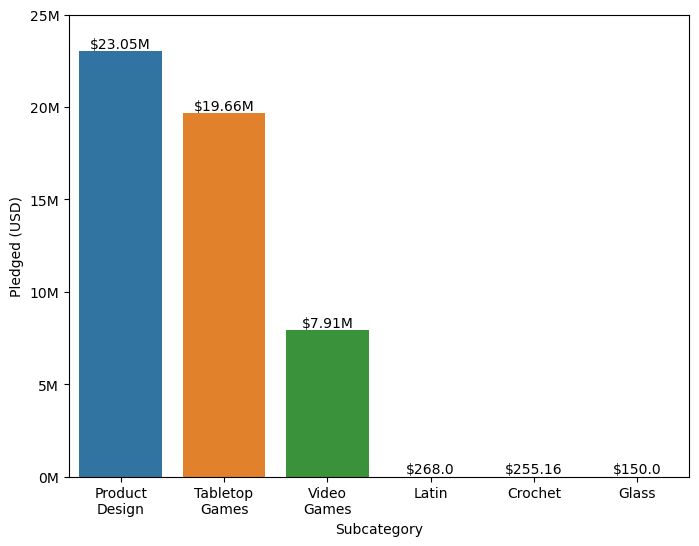

In [19]:
def build_query(ascending: bool, limit: int, SQL_GET_SUBCATEGORY=SQL_GET_SUBCATEGORY, SQL_CAMPAIGN_PLEDGED_USD = SQL_CAMPAIGN_PLEDGED_USD):
    query = f'''
                SELECT      Round(Sum(t1.pledged_usd),2)    AS pledged_usd,
                            t2.subcategory_name
                FROM        ({SQL_CAMPAIGN_PLEDGED_USD})    AS t1
                INNER JOIN  ({SQL_GET_SUBCATEGORY})         AS t2
                ON          t1.campaign_id = t2.campaign_id
                WHERE       t1.outcome != "live"
                GROUP BY    t2.subcategory_name
                ORDER BY    pledged_usd {"ASC" if ascending else "DESC"} 
                LIMIT       {limit}; 
            '''
    return query

# Build dataframe from SQL queries
df1 = build_dataframe_from_queries(get_top_bottom_3(build_query), con)
df1.sort_values(by="pledged_usd", ascending=False, inplace=True)
df1["subcategory_name"] = df1["subcategory_name"].apply(lambda x: x.replace(" ", "\n") if " " in x else x)
print(df1)

# Create visualization
plt.figure(figsize=(8,6))
sns.barplot(x="subcategory_name", y="pledged_usd", data=df1)
plt.ylabel("Pledged (USD)")
plt.xlabel("Subcategory")

plt.yticks(
    np.arange(0, 3e7, 0.5e7), [f"{y/1e6:.0f}M" for y in np.arange(0, 3e7, .5e7)]
)
for i, pledged_usd in enumerate(df1["pledged_usd"]):
    if pledged_usd >= 1e6:
        plt.annotate(f"${round(pledged_usd/1e6, 2)}M", (i, pledged_usd), ha="center", va="bottom")
    elif pledged_usd >= 1e3:
        plt.annotate(f"${round(pledged_usd/1e3, 2)}K", (i, pledged_usd), ha="center", va="bottom")
    elif pledged_usd < 1e3:
        plt.annotate(f"${pledged_usd}", (i, pledged_usd), ha="center", va="bottom")
plt.show()

- The top 3 categories that have raised the most money are Games ($29.03M), Technology ($28.05M), and Design ($26.3M).
- The bottom 3 categories have raised the least money are Journalism ($608K), Dance ($512K), and Crafts ($450K).
- The top 3 sub-categories that have raised the most money are Product Design ($23.05M), Tabletop Games ($19.66M), and Video Games ($7.91M).
- The bottom 3 sub-categories have raised the least money are Glass ($150), Photo ($255), and Latin ($268).

# What was the amount the most successful board game company raised? How many backers did they have?

In [ ]:
%%sql
SELECT campaign.id AS campaign_id,
       campaign.name,
       t1.pledged_usd,
       campaign.backers,
       t2.subcategory_name,
       Date(campaign.deadline) as deadline
FROM   campaign
       INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS
                                          pledged_usd,
                             campaign.outcome as outcome
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
       INNER JOIN (SELECT campaign.id       AS campaign_id,
                          sub_category.name AS subcategory_name
                   FROM   campaign,
                          sub_category
                   WHERE  campaign.sub_category_id = sub_category.id
                   GROUP  BY campaign.id) AS t2
               ON campaign.id = t2.campaign_id
WHERE  t2.subcategory_name = "Tabletop Games"
AND t1.outcome != "live"
GROUP  BY campaign.id
ORDER  BY pledged_usd DESC
LIMIT  3;  


 * sqlite:///database.db
Done.


campaign_id,name,pledged_usd,backers,subcategory_name,deadline
9960,Gloomhaven (Second Printing),3999795.77,40642,Tabletop Games,2017-05-02
7703,"Ghostbusters"": The Board Game",1546269.5,8396,Tabletop Games,2015-03-12
5072,Shadows of Brimstone,1341305.03,4727,Tabletop Games,2013-11-25


- The amount that the most successful board game campaign raised was ~$4M by Gloomhaven (Second Printing) in 2017. They were backed by 40,642 backers.

# Rank the top three countries with the most successful campaigns in terms of dollars (total amount pledged), and in terms of the number of campaigns backed.

In [273]:
%%sql
SELECT t2.country_name,
       Count(campaign.id)            AS num_campaigns,
       Round(Sum(t1.pledged_usd), 2) AS pledged_usd
FROM   campaign
       INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd,
                          campaign.outcome as outcome
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
       INNER JOIN (SELECT country.id         AS country_id,
                          country.name       AS country_code,
                          country_codes.name AS country_name
                   FROM   country
                          LEFT JOIN country_codes
                                 ON country_codes.code = country.name) AS t2
               ON campaign.country_id = t2.country_id
WHERE  t1.outcome = "successful"
GROUP  BY campaign.country_id
ORDER  BY pledged_usd DESC
LIMIT  3;  


 * sqlite:///database.db
Done.


country_name,num_campaigns,pledged_usd
United States,4364,100951684.55
United Kingdom,487,5577063.47
Canada,137,2271189.19


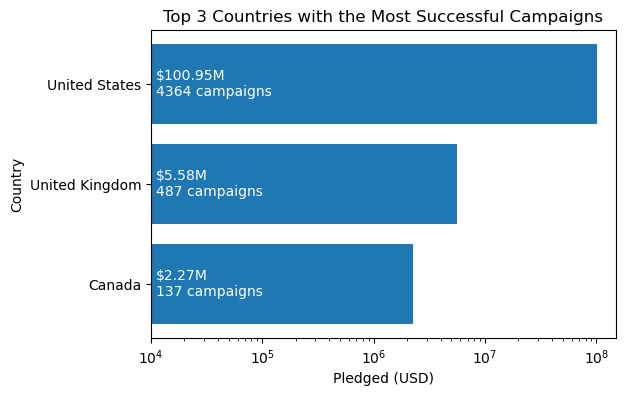

In [139]:
subquery = '''
SELECT t2.country_name,
       Count(campaign.id)            AS num_campaigns,
       Round(Sum(t1.pledged_usd), 2) AS pledged_usd
FROM   campaign
       INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd,
                          campaign.outcome as outcome
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
       INNER JOIN (SELECT country.id         AS country_id,
                          country.name       AS country_code,
                          country_codes.name AS country_name
                   FROM   country
                          LEFT JOIN country_codes
                                 ON country_codes.code = country.name) AS t2
               ON campaign.country_id = t2.country_id
WHERE  t1.outcome = "successful"
'''
query1 = f'''
{subquery}
GROUP  BY campaign.country_id
ORDER  BY pledged_usd DESC
LIMIT  3;  
'''
query2 = f'''
{subquery}
GROUP  BY campaign.country_id
ORDER  BY num_campaigns DESC
LIMIT  3;  
'''
df1 = build_dataframe_from_queries([query1], con)
df1.sort_values(by='pledged_usd', ascending=True, inplace=True)
plt.figure(figsize=(6, 4))
plt.barh(df1['country_name'], df1['pledged_usd'])
plt.xscale('log')  # Add this line to convert x-axis to log scale
plt.xlim(1e4, 1.5e8)
plt.xlabel('Pledged (USD)')
plt.ylabel('Country')
plt.title('Top 3 Countries with the Most Successful Campaigns')
# Add label annotations
for i, pledged_usd in enumerate(df1['pledged_usd']):
       num_campaigns = df1['num_campaigns'].iloc[i]
       if pledged_usd >= 1e6:
              plt.text(1.1e4, i, f'${pledged_usd/1e6:.2f}M\n{num_campaigns} campaigns', ha='left', va='center', color='white')
       elif pledged_usd >= 1e3:
              plt.text(pledged_usd, i, f'${pledged_usd/1e3:.2f}K', ha='left', va='center')
              plt.text(1.1e4, i, f'{pledged_usd/1e3:.2f}K\n{num_campaigns} campaigns', ha='left', va='center', color='white')

plt.show()

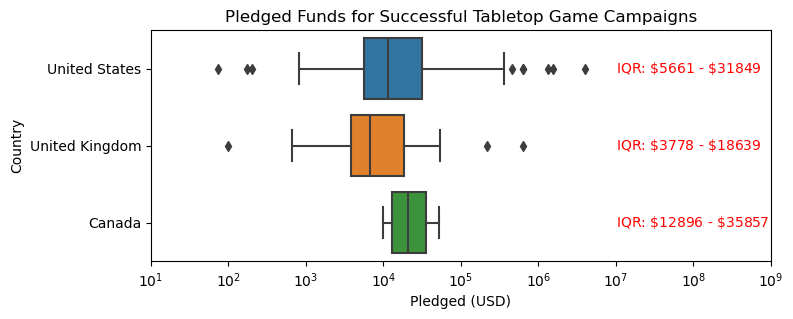

In [264]:
import seaborn as sns
query = '''
SELECT t2.country_name AS country,
       t1.pledged_usd AS pledged_usd
FROM   campaign
       INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd,
                          campaign.outcome as outcome
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
       INNER JOIN (SELECT country.id         AS country_id,
                          country.name       AS country_code,
                          country_codes.name AS country_name
                   FROM   country
                          LEFT JOIN country_codes
                                 ON country_codes.code = country.name) AS t2
               ON campaign.country_id = t2.country_id
WHERE  t1.outcome = "successful"
AND campaign.sub_category_id = 14
AND t2.country_code IN ("US", "GB", "CA")
ORDER  BY pledged_usd DESC  
'''
df1 = build_dataframe_from_queries([query], con)
df1['pledged_usd'] = df1['pledged_usd'].apply(lambda x: np.log10(x))

results = df1.groupby("country").describe()
results["lower_95CI"] = results["pledged_usd"]["mean"] - 1.96 * results["pledged_usd"]["std"] / np.sqrt(results["pledged_usd"]["count"])
results["upper_95CI"] = results["pledged_usd"]["mean"] + 1.96 * results["pledged_usd"]["std"] / np.sqrt(results["pledged_usd"]["count"])
results["mean"] = results["pledged_usd"]["mean"].apply(lambda x: 10**x)
results["lower_95CI"] = results["lower_95CI"].apply(lambda x: 10**x)
results["upper_95CI"] = results["upper_95CI"].apply(lambda x: 10**x)
results["_25%"] = results["pledged_usd"]["25%"].apply(lambda x: 10**x)
results["_50%"] = results["pledged_usd"]["50%"].apply(lambda x: 10**x)
results["_75%"] = results["pledged_usd"]["75%"].apply(lambda x: 10**x)

plt.figure(figsize=(8, 3))
sns.boxplot(y=df1['country'], x=df1['pledged_usd'])
plt.xticks(np.arange(1, 10, 1), [f'$10^{{{y:.0f}}}$' for y in np.arange(1, 10, 1)])
plt.xlabel('Pledged (USD)')
plt.ylabel('Country')
# Add title
plt.title('Pledged Funds for Successful Tabletop Game Campaigns')
# Add IQR labels
for i, country in enumerate(df1['country'].unique()):
       lower = results.loc[country, '_25%'].values[0]
       upper = results.loc[country, '_75%'].values[0]
       max = results.loc[country, ('pledged_usd', 'max')]
       plt.text(7, i, f'IQR: ${{\${lower:.0f}}}$ - ${{\${upper:.0f}}}$', ha='left', va='center', color='red')

plt.show()


In [244]:
results

pledged_usd                                                    \
                     count      mean       std       min       25%       50%   
country                                                                        
Canada                 5.0  4.339959  0.302568  3.990939  4.110445  4.322646   
United Kingdom        35.0  3.894624  0.677601  1.994229  3.577247  3.826927   
United States        224.0  4.121100  0.691847  1.869232  3.752866  4.060444   

                                      lower_95CI    upper_95CI          mean  \
                     75%       max                                             
country                                                                        
Canada          4.554575  4.721193  11878.095150  40287.672449  21875.575575   
United Kingdom  4.270428  5.799905   4678.800681  13155.698359   7845.565018   
United States   4.503095  6.602038  10727.456439  16281.806009  13215.988980   

                         25%           50%           75%  
                                                          
country                                                   
Canada          12895.710000  21020.630000  35857.060000  
United Kingdom   3777.867294   6713.160000  18639.251357  
United States    5660.651359  11493.279515  31848.950513

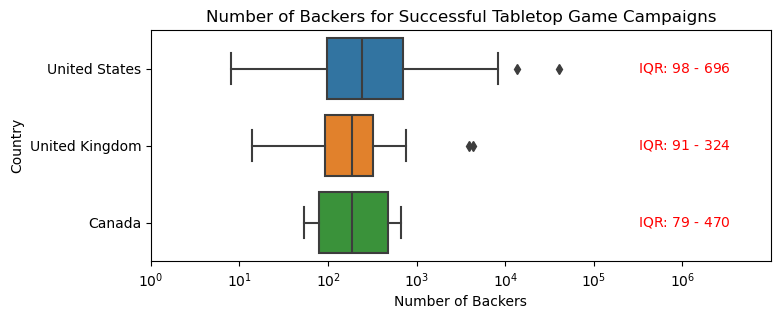

In [266]:
query = '''
SELECT t2.country_name AS country,
       backers
FROM   campaign
       INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd,
                          campaign.outcome as outcome
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
       INNER JOIN (SELECT country.id         AS country_id,
                          country.name       AS country_code,
                          country_codes.name AS country_name
                   FROM   country
                          LEFT JOIN country_codes
                                 ON country_codes.code = country.name) AS t2
               ON campaign.country_id = t2.country_id
WHERE  t1.outcome = "successful"
AND campaign.sub_category_id = 14
AND t2.country_code IN ("US", "GB", "CA")
ORDER  BY pledged_usd DESC  
'''
df1 = build_dataframe_from_queries([query], con)
df1["backers"] = df1["backers"].apply(lambda x: np.log10(x))
results = df1.groupby("country").describe()
results["lower_95CI"] = results["backers"]["mean"] - 1.96 * results["backers"]["std"] / np.sqrt(results["backers"]["count"])
results["upper_95CI"] = results["backers"]["mean"] + 1.96 * results["backers"]["std"] / np.sqrt(results["backers"]["count"])
results["mean"] = results["backers"]["mean"].apply(lambda x: 10**x)
results["lower_95CI"] = results["lower_95CI"].apply(lambda x: 10**x)
results["upper_95CI"] = results["upper_95CI"].apply(lambda x: 10**x)
results["25%"] = results["backers"]["25%"].apply(lambda x: 10**x)
results["50%"] = results["backers"]["50%"].apply(lambda x: 10**x)
results["75%"] = results["backers"]["75%"].apply(lambda x: 10**x)

plt.figure(figsize=(8,3))
sns.boxplot(y=df1['country'], x=df1['backers'])
plt.xlabel('Number of Backers')
plt.xticks(np.arange(0, 7, 1), [f'$10^{{{y:.0f}}}$' for y in np.arange(0, 7, 1)])
plt.xlim(0, 7)
plt.ylabel('Country')
# Add title
plt.title('Number of Backers for Successful Tabletop Game Campaigns')
# Add IQR labels
for i, country in enumerate(df1['country'].unique()):
       lower = results.loc[country, ('backers', '25%')]
       upper = results.loc[country, ('backers', '75%')]
       max = results.loc[country, ('backers', 'max')]
       plt.text(5.5, i, f'IQR: ${{{10**lower:.0f}}}$ - ${{{10**upper:.0f}}}$', ha='left', va='center', color='red')

plt.show()

In [267]:
results

backers                                                    \
                 count      mean       std       min       25%       50%   
country                                                                    
Canada             5.0  2.277952  0.472940  1.732394  1.897627  2.264818   
United Kingdom    35.0  2.257589  0.539571  1.146128  1.961103  2.271842   
United States    224.0  2.432222  0.622278  0.903090  1.993419  2.384711   

                                    lower_95CI  upper_95CI        mean  \
                     75%       max                                       
country                                                                  
Canada          2.672098  2.822822   73.013279  492.607951  189.649471   
United Kingdom  2.510981  3.641474  119.902650  273.117092  180.962602   
United States   2.842765  4.608975  224.248526  326.372953  270.534016   

                      25%         50%         75%  
                                                   
country                                            
Canada          79.000000  184.000000  470.000000  
United Kingdom  91.433036  187.000000  324.325454  
United States   98.496167  242.499485  696.249865

# Do longer, or shorter campaigns tend to raise more money? Why?

    campaign_length  pledged_usd     outcome
0              30.0       3.9577  successful
4              21.0       3.5892  successful
5               8.0       3.6615  successful
8              30.0       2.9101  successful
11             32.0       3.9072  successful
                            OLS Regression Results                            
Dep. Variable:            pledged_usd   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     8.171
Date:                Thu, 23 Nov 2023   Prob (F-statistic):            0.00456
Time:                        18:54:53   Log-Likelihood:                -304.18
No. Observations:                 294   AIC:                             612.4
Df Residuals:                     292   BIC:                             619.7
Df Model:                           1                                         
Covariance Type:   

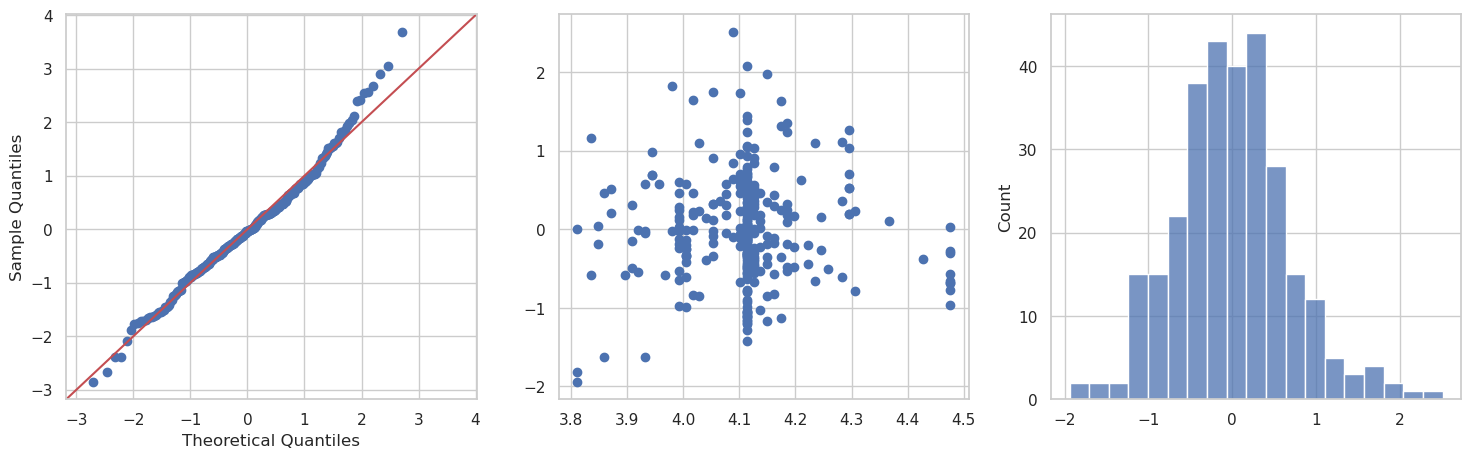

In [201]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
query = f'''
SELECT 
JULIANDAY(campaign.deadline)-JULIANDAY(campaign.launched) AS campaign_length,
pledged_usd,
outcome
FROM  campaign
INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
INNER JOIN  ( {SQL_GET_SUBCATEGORY})          AS t2
ON          t1.campaign_id = t2.campaign_id
WHERE t2.subcategory_name = "Tabletop Games"
'''
df1 = build_dataframe_from_queries([query], con)
df1['pledged_usd'] = df1['pledged_usd'].apply(lambda x: round(np.log10(x),4) if x > 0 else 0)
df1 = df1[df1.outcome == "successful"]
print(df1.head())

# Fit ANOVA model
model = ols('pledged_usd ~ campaign_length', data=df1).fit()
print(model.summary())

# Check assumptions
residuals = model.resid
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sm.qqplot(residuals, ax=axes[0], line="45", fit=True)
axes[1].scatter(model.fittedvalues, residuals)
sns.histplot(ax=axes[2], data=residuals)

# Display the plots
plt.show()



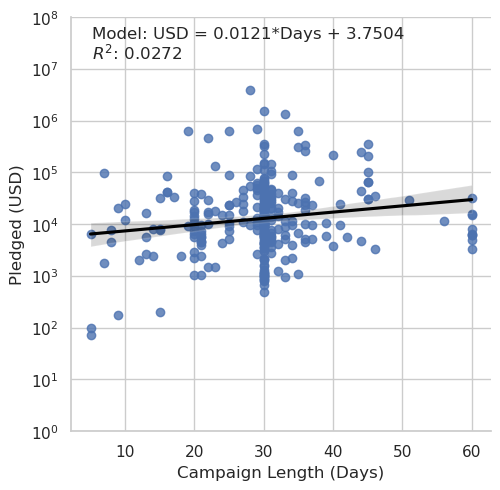

In [202]:
import seaborn as sns
# Perform linear regression

# Create the linear regression model
reg = LinearRegression()

# Prepare the features and target variables
X = df1[['campaign_length']]
y = df1['pledged_usd']

# Fit the model to the data
reg.fit(X, y)


# Create a scatter plot of campaign length vs. pledged (USD)
sns.lmplot(x='campaign_length', y='pledged_usd', data=df1, line_kws={'color': 'black'})

# Add model equation and R-squared value to the plot
plt.text(0.05, 0.95, f"Model: USD = {reg.coef_[0]:.4f}*Days + {reg.intercept_:.4f}", transform=plt.gca().transAxes)
plt.text(0.05, 0.90, f"$R^2$: {reg.score(X, y):.4f}", transform=plt.gca().transAxes)

# Relabel y-axis ticks to scientific notation
plt.yticks(
    np.arange(0, 9, 1), [f"$10^{y:.0f}$" for y in np.arange(0, 9, 1)])
# Set labels for x-axis and y-axis

plt.ylabel("Pledged (USD)")
plt.xlabel("Campaign Length (Days)")

# Show the plot
plt.show()

   campaign_length  pledged_usd       outcome
0             30.0       1.3010  unsuccessful
1             30.0       2.4404    successful
2             30.0       3.1752  unsuccessful
3             30.0       3.9442    successful
4             35.0       0.3010  unsuccessful


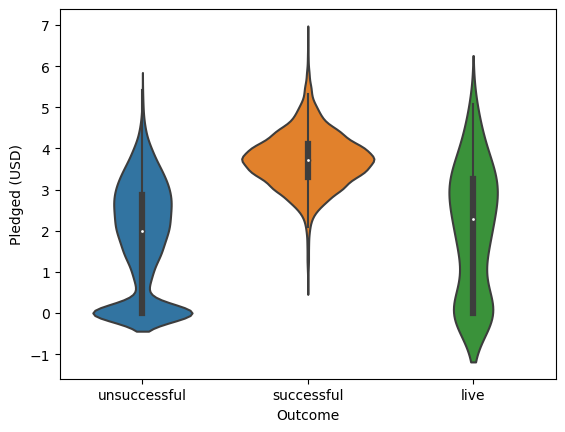

In [ ]:
import seaborn as sns
query = '''
SELECT 
JULIANDAY(campaign.deadline)-JULIANDAY(campaign.launched) AS campaign_length,
pledged_usd,
CASE
         WHEN ( outcome IN ( "failed", "canceled", "suspended", "undefined" ) )
       THEN
         "unsuccessful"
         ELSE outcome
       END AS outcome
FROM  campaign
INNER JOIN (SELECT campaign.id
                          AS
                          campaign_id,
                          Round(campaign.pledged * exchange_rate.exchange_rate,
                          2) AS pledged_usd
                   FROM   campaign,
                          exchange_rate
                   WHERE  exchange_rate.currency_id = campaign.currency_id
                          AND exchange_rate.deadline = Date(campaign.deadline))
                  AS t1
               ON campaign.id = t1.campaign_id
'''
df1 = build_dataframe_from_queries([query], con)
df1['pledged_usd'] = df1['pledged_usd'].apply(lambda x: round(np.log10(x),4) if x > 0 else 0)
print(df1.head())

sns.violinplot(x='outcome', y='pledged_usd', data=df1)
plt.xlabel('Outcome')
plt.ylabel('Pledged (USD)')
plt.show()
